In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

In [2]:
def leerDescripciones(numDescripciones, fichero):
    dataset = np.loadtxt(fichero, delimiter = '\n', max_rows=numDescripciones, encoding="ISO-8859-1", dtype = 'str', unpack = True)
    cabecera = dataset[0].split('\t')
    numColumnas = len(cabecera)
    columnas = {}
    for i in range(numColumnas):
        columnas[i] = cabecera[i]
    dataset1 = []
    for i in range(1,numDescripciones):
        if len(dataset[i].split('\t')) == numColumnas:
            dataset1.append(dataset[i].split('\t'))
    dataset = np.array(dataset1)
    return dataset,columnas

In [3]:
dataset, columnas = leerDescripciones(150, 'SemArt/semart_test.csv')

In [4]:
print(dataset.shape)
print(columnas)

(142, 9)
{0: 'IMAGE_FILE', 1: 'DESCRIPTION', 2: 'AUTHOR', 3: 'TITLE', 4: 'TECHNIQUE', 5: 'DATE', 6: 'TYPE', 7: 'SCHOOL', 8: 'TIMEFRAME'}


In [5]:
def guardarCuadros(pathDirectorio,dataset):
    pathsCompletos = pathDirectorio+'/*'
    cuadrosDistintos = np.unique(dataset[:,0])
    nCuadrosDistintos = len(cuadrosDistintos)
    nombreCuadros = []
    nombreCuadro = cuadrosDistintos[0]
    nombreCuadros.append(dataset[dataset[:,0] == nombreCuadro,3])
    cuadro = cv2.imread(pathDirectorio+'/'+nombreCuadro,0)
    dimensionesCuadros = cuadro.shape
    dimensionesCuadros = (3000,3000)
    cuadros = np.zeros((cuadro.size,nCuadrosDistintos))
    cuadros = np.zeros((3000**2,nCuadrosDistintos))
    cuadros[:,0] = cv2.resize(cuadro, (dimensionesCuadros[1], dimensionesCuadros[0])).reshape(-1)
    for i, nombreCuadro in enumerate(cuadrosDistintos[1:]):
        nombreCuadros.append(dataset[dataset[:,0] == nombreCuadro,3])
        cuadro = cv2.imread(pathDirectorio+'/'+nombreCuadro,0)
        cuadro = cv2.resize(cuadro, (dimensionesCuadros[1], dimensionesCuadros[0]))
        cuadros[:,i] = cuadro.reshape(-1)
    nombreCuadros = np.array(nombreCuadros).ravel()
    return cuadros,nombreCuadros, dimensionesCuadros

In [6]:
cuadros, nombreCuadros, dimensionesCuadros = guardarCuadros('SemArt/Images',dataset)
print(cuadros.shape)
print(dimensionesCuadros)

(9000000, 142)
(3000, 3000)


tenemos 142 cuadros distintos
Jael and Sisera


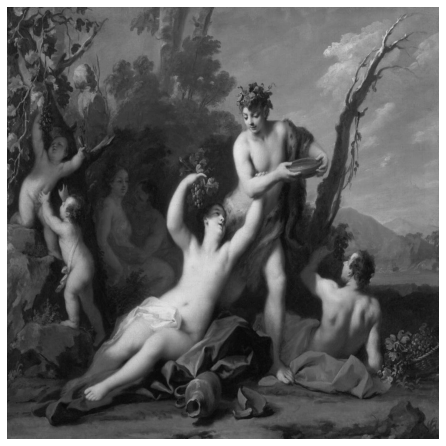

Bacchus and Ariadne


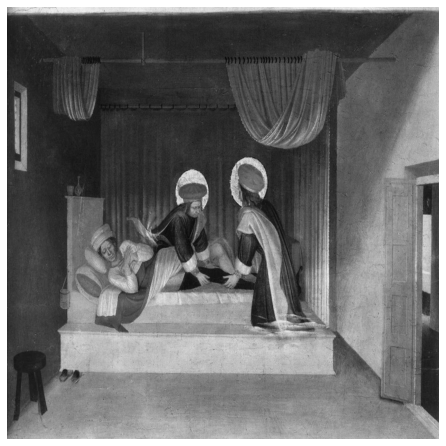

The Healing of Justinian by Saint Cosmas and Saint Damian


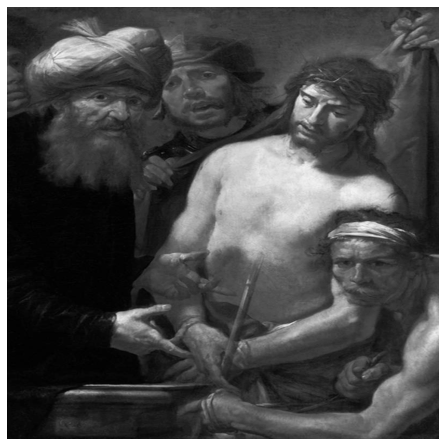

Ecce Homo


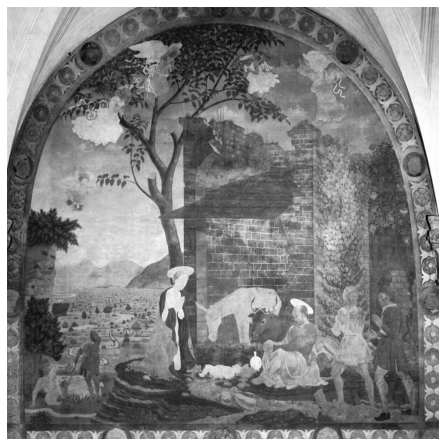

Nativity


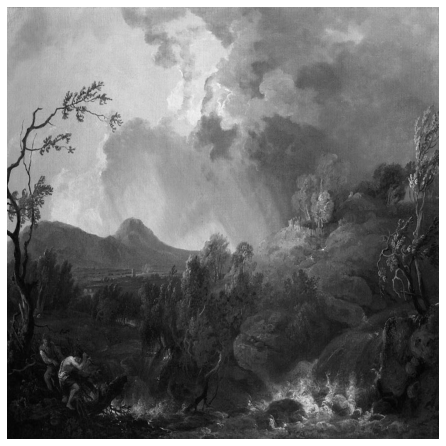

Landscape with an Approaching Shower


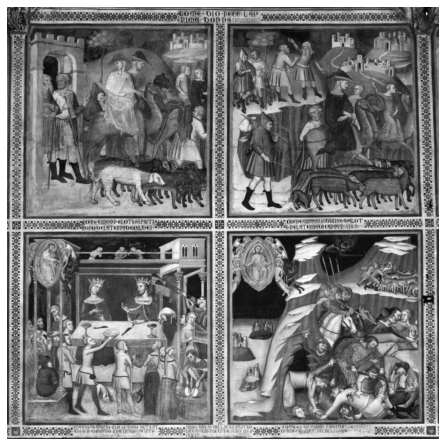

Scenes from the Old Testament


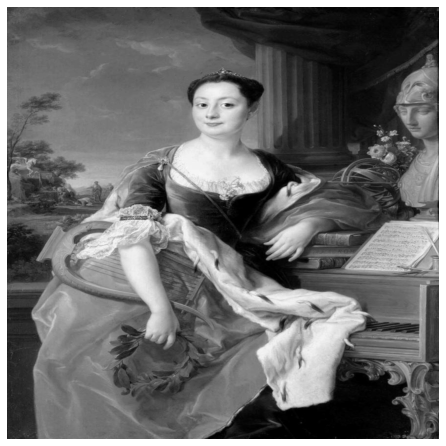

Portrait of Princess Giacinta Orsini Buoncampagni Ludovisi


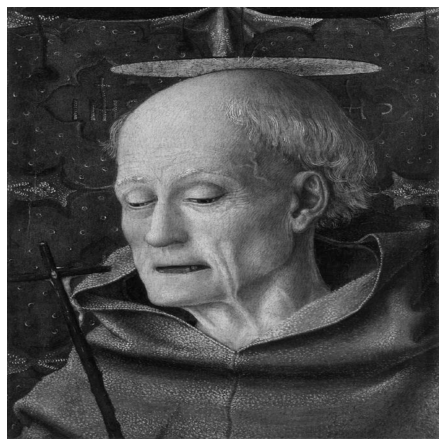

St Bernardino da Siena


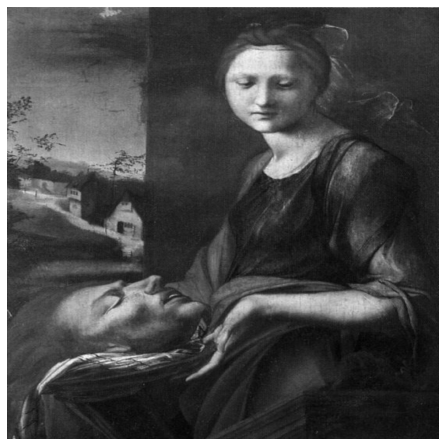

Salome


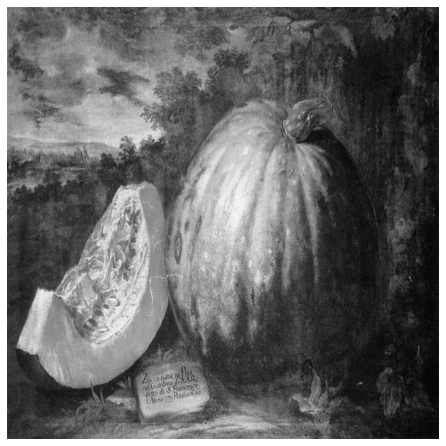

In [7]:
nCuadrosDistintos = cuadros.shape[1]
print('tenemos {} cuadros distintos'.format(nCuadrosDistintos))
for i in range(10):
    print(nombreCuadros[i])
    fig = plt.figure(figsize=(8, 6))
    axes = fig.add_axes([0, 0, 1, 1])
    plt.imshow(cuadros[:,i].reshape(dimensionesCuadros), cmap = 'gray')
    plt.axis('off')
    plt.show();

In [8]:
def aplicaPCACuadros(cuadros,nComponentes = None):
    pca = PCA(n_components=nComponentes)
    PCAs = np.zeros(cuadros.shape)
    pca.fit(cuadros)
    PCAs = pca.components_
    print('De media mantenemos el {}% de la información de los cuadros'.format(round(np.sum(pca.explained_variance_ratio_)*100, 2)))
    return PCAs

In [9]:
nComponentes = nCuadrosDistintos
cuadros = cuadros/255
PCAs = aplicaPCACuadros(cuadros, nComponentes)
print(PCAs.shape)

De media mantenemos el 100.0% de la información de los cuadros
(142, 142)


In [10]:
def cogeCuadrosTipo(tipo, nombreCuadros, PCAs):
    nombresCuadrosDelTipo = dataset[dataset[:,6] == tipo, 3]
    indices = np.zeros((nombreCuadros.size)).astype('bool')
    for nombreCuadroDelTipo in nombresCuadrosDelTipo:
        indices = indices+(nombreCuadroDelTipo == nombreCuadros)
    cuadrosDelTipo = PCAs[indices]
    return cuadrosDelTipo

In [11]:
#creo una lista de cuadros separados por categorias
categorias = np.unique(dataset[:,6])
cuadrosPorCategorias = []
for categoria in categorias:
    cuadrosPorCategorias.append(cogeCuadrosTipo(categoria, nombreCuadros, PCAs))

In [12]:
def eligeNumeroClusters(nComponentes, cuadros):
    puntuacionesSilueta = np.zeros((nComponentes-2))
    for k in range(2,nComponentes):
        kMeans = KMeans(n_clusters = k, random_state = 42).fit(cuadros)
        puntuacionesSilueta[k-2] = silhouette_score(cuadros,kMeans.labels_)
    kOptimo = np.argmax(puntuacionesSilueta)+2
    return kOptimo

El numero optimo de clusters para la categoria GENRE es 2


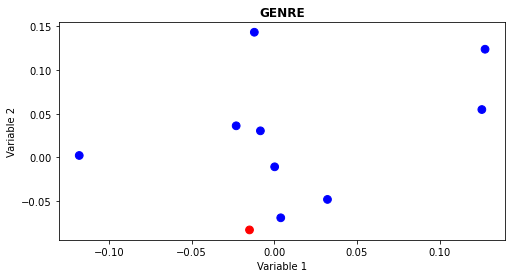

El numero optimo de clusters para la categoria HISTORICAL es 5


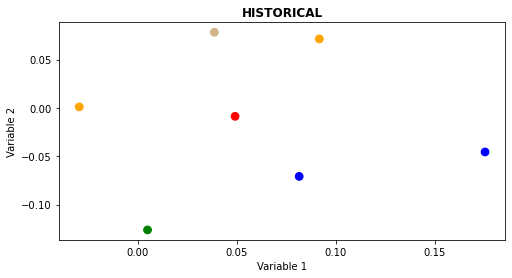

El numero optimo de clusters para la categoria INTERIOR es 3


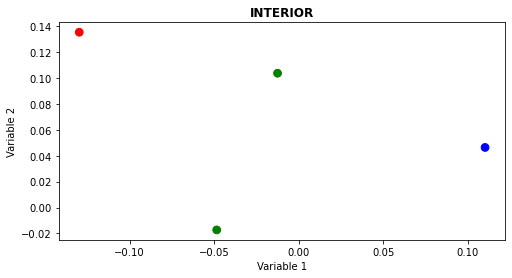

El numero optimo de clusters para la categoria LANDSCAPE es 3


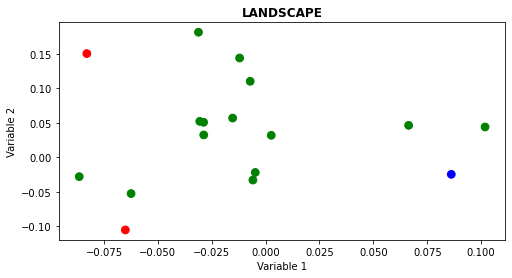

El numero optimo de clusters para la categoria MYTHOLOGICAL es 3


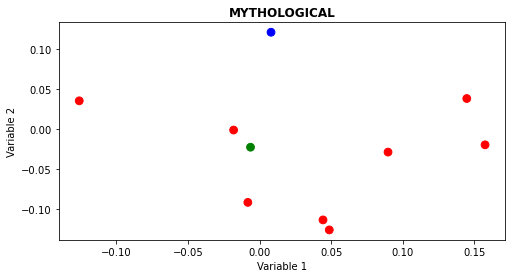

El numero optimo de clusters para la categoria OTHER es 2


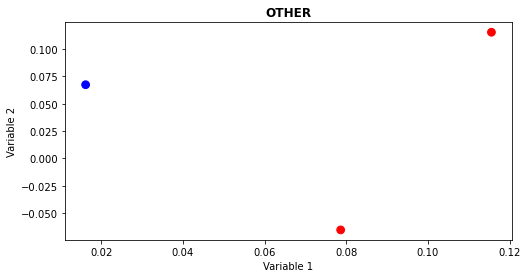

El numero optimo de clusters para la categoria PORTRAIT es 18


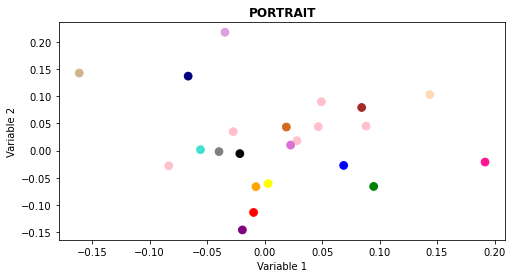

El numero optimo de clusters para la categoria RELIGIOUS es 2


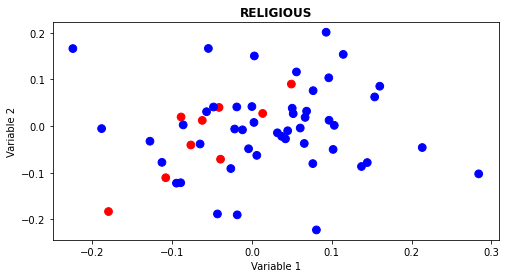

El numero optimo de clusters para la categoria STILL-LIFE es 2


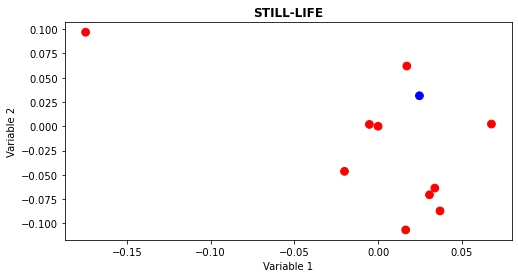

In [54]:
colors =["red", "purple","brown", "pink", "orange", "gray", "turquoise", "DeepPink", "yellow","green", "black", "chocolate", "navy", "tan", "plum", "PeachPuff", "orchid", "blue"]
cmap_bold = ListedColormap(colors)
for i,cuadros in enumerate(cuadrosPorCategorias):
    kOptimo = eligeNumeroClusters(min(len(cuadros), nComponentes), cuadros)
    print('El numero optimo de clusters para la categoria \033[1m{}\033[0m es {}'.format(categorias[i].upper(), kOptimo))
    kMeans = KMeans(n_clusters = kOptimo, random_state = 42).fit(cuadros)
    plt.figure(figsize=(8,4))
    plt.subplot(111)
    plt.scatter(cuadros[:, 0], cuadros[:, 1], c=kMeans.labels_, cmap=cmap_bold, s=60)
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.title(categorias[i].upper(), fontweight="bold")
    plt.show()